<a href="https://colab.research.google.com/github/habazaki2001/bai-tap-use-state/blob/main/Tuber_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 The Dataset

## 1.1 Kaggle API json token

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

## 1.2 Download the dataset

By providing the Kaggle Dataset API command.

In [26]:
! kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset
License(s): copyright-authors
tuberculosis-tb-chest-xray-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


## 1.3 Unzipping


In [27]:
import zipfile
zf = "/content/tuberculosis-tb-chest-xray-dataset.zip"
target_dir = "/content/dataset/cnn/tuberculosis_revamped"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

## 1.4 Spliting to Train, Validation, Test

In [28]:
!pip install split-folders

In [29]:
import splitfolders

splitfolders.ratio(
    "/content/dataset/cnn/tuberculosis_revamped/TB_Chest_Radiography_Database",
    output="/content/dataset/cnn/tuberculosis",
    seed=1337,
    ratio=(.7, .2, .1),
    group_prefix=None
)


Copying files: 4200 files [00:03, 1354.86 files/s]


In [30]:
!rm -r "/content/dataset/cnn/tuberculosis_revamped"

Following code is to make test directory have a single folder with both Normal and Tuberculosis datas.
In our case we do not require this part of the code hence its commented.

In [31]:
# !mv  -v /content/dataset/cnn/tuberculosis/test/Normal/* /content/dataset/cnn/tuberculosis/test/
# !mv  -v /content/dataset/cnn/tuberculosis/test/Tuberculosis/* /content/dataset/cnn/tuberculosis/test/
# !rm -r /content/dataset/cnn/tuberculosis/test/Normal
# !rm -r /content/dataset/cnn/tuberculosis/test/Tuberculosis

# 2 Initialize

## 2.1 Basic Imports

In [32]:
#Some Basic Imports
import matplotlib.pyplot as plt #For Visualization
import numpy as np              #For handling arrays
import pandas as pd             # For handling data

## 2.2 Define Directories

In [33]:
#Define Directories for train, test & Validation Set
train_path = '/content/dataset/cnn/tuberculosis/train'
test_path = '/content/dataset/cnn/tuberculosis/test'
valid_path = '/content/dataset/cnn/tuberculosis/val'

## 2.3 Basic Parameters

In [34]:
#The batch refers to the number of training examples utilized in one #iteration
batch_size = 16
#The dimension of the images we are going to define is 500x500 img_height = 500
img_height = 500
img_width = 500

# 3 Preparing the Data

## 3.1 Data Augmentation

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                rescale = 1./255,
                                #shear_range = 0,
                                #zoom_range = 0,
                                horizontal_flip = True,
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [36]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )

test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False,
      class_mode='binary',
      batch_size=batch_size
      )

valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )

Found 2939 images belonging to 2 classes.
Found 421 images belonging to 2 classes.
Found 840 images belonging to 2 classes.


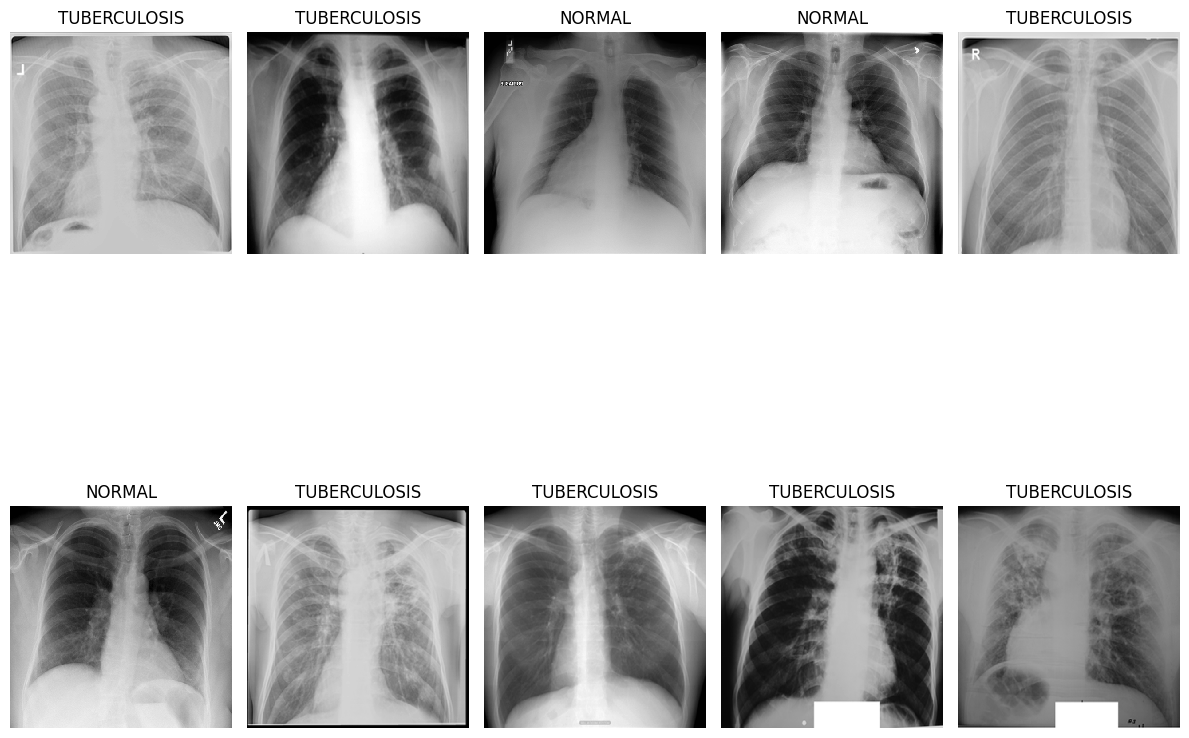

In [37]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]
        dic = {0:'NORMAL', 1:'TUBERCULOSIS'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

# 4 Convolutional Neural Network

## 4.1 Necessary Imports

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

## 4.2 CNN Architecture

In [38]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))

Model Compile

In [39]:
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Model Summary

In [40]:
cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 498, 498, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 249, 249, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 247, 247, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 123, 123, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 121, 121, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 58, 58, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 29, 29, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 27, 27, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 10816)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       1,384,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,467,137 (5.60 MB)

 Trainable params: 1,467,137 (5.60 MB)

 Non-trainable params: 0 (0.00 B)

Visualize CNN model

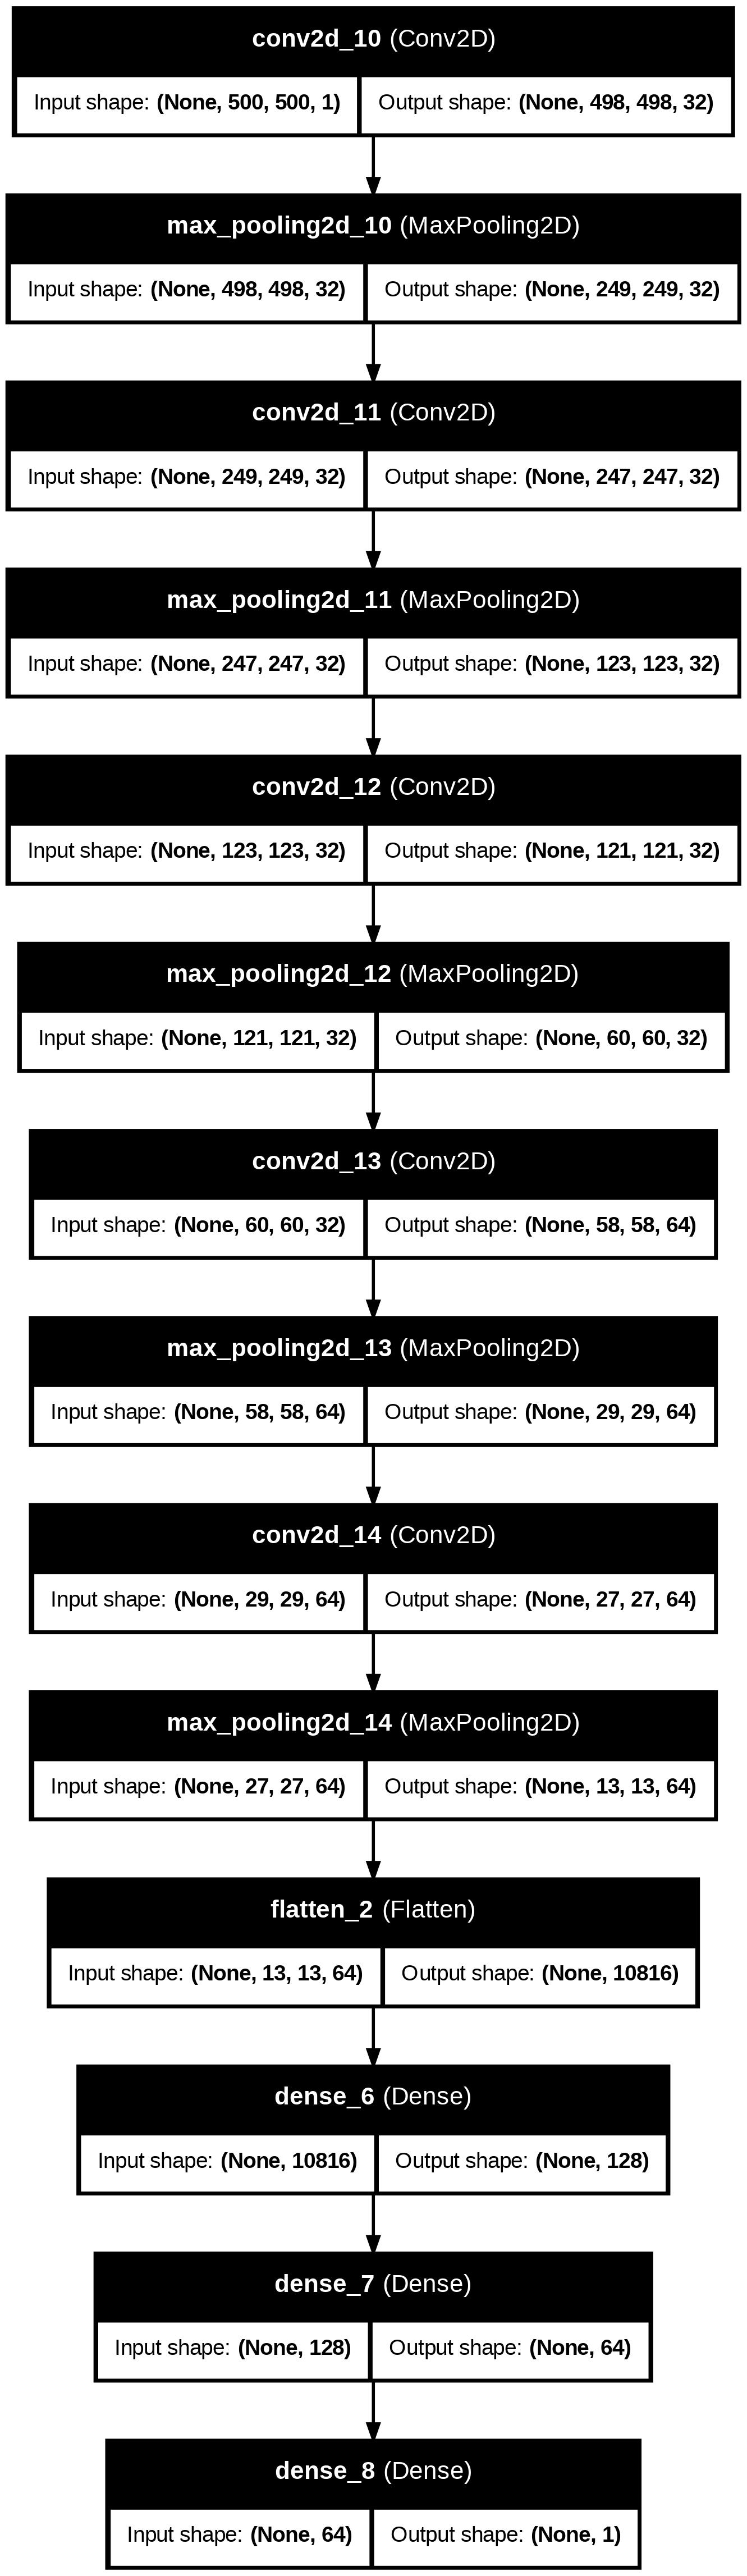

In [41]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

## 4.3 Fit the model

Defining callback list

In [42]:
early = EarlyStopping(monitor= "val_loss", mode= "min", patience= 3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

Assigning Class Weights

In [44]:
weights = compute_class_weight(class_weight='balanced', classes=np.unique(train.classes), y=train.classes)
cw = dict(zip(np.unique(train.classes), weights))
print(cw)

{0: 0.5997959183673469, 1: 3.005112474437628}


Training

In [45]:
cnn.fit(train,epochs=25, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


184/184 ━━━━━━━━━━━━━━━━━━━━ 62s 259ms/step - accuracy: 0.7400 - loss: 0.5910 - val_accuracy: 0.6488 - val_loss: 0.5851 - learning_rate: 0.0010
Epoch 2/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 37s 198ms/step - accuracy: 0.8501 - loss: 0.2938 - val_accuracy: 0.8202 - val_loss: 0.3679 - learning_rate: 0.0010
Epoch 3/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 40s 215ms/step - accuracy: 0.9019 - loss: 0.2180 - val_accuracy: 0.9679 - val_loss: 0.1044 - learning_rate: 0.0010
Epoch 4/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 38s 202ms/step - accuracy: 0.9348 - loss: 0.1567 - val_accuracy: 0.9333 - val_loss: 0.1897 - learning_rate: 0.0010
Epoch 5/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9560 - loss: 0.1027
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
184/184 ━━━━━━━━━━━━━━━━━━━━ 38s 201ms/step - accuracy: 0.9560 - loss: 0.1028 - val_accuracy: 0.8714 - val_loss: 0.3083 - learning_rate: 0.0010
Epoch 6/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 38s 200ms/step - accuracy: 0.9691 - loss: 0

# 5 Evaluate

<Axes: >

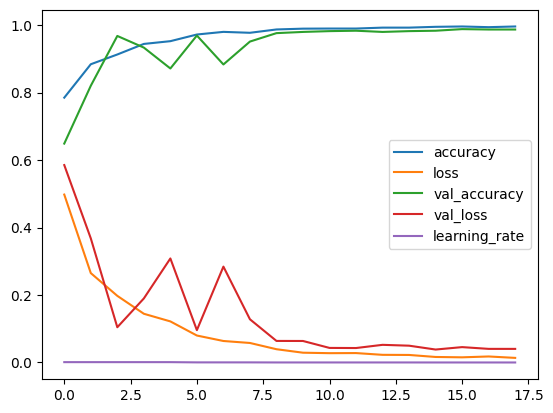

In [46]:
pd.DataFrame(cnn.history.history).plot()

In [47]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

 1/27 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.9375 - loss: 0.2711

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - accuracy: 0.9831 - loss: 0.0648
The testing accuracy is : 98.33729267120361 %


In [48]:
preds = cnn.predict(test,verbose=1)

27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step


In [49]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

Confussion Matrix

<Axes: >

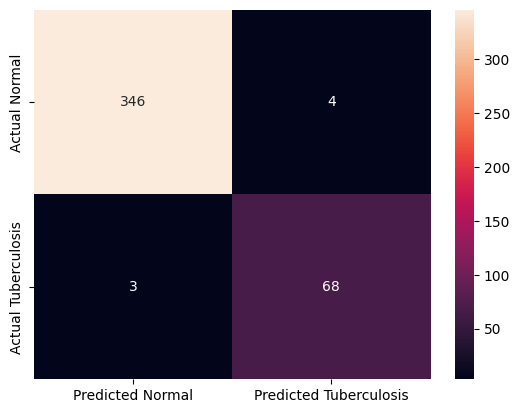

In [50]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Tuberculosis"],
columns=["Predicted Normal", "Predicted Tuberculosis"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

Classification Report

In [51]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','TUBERCULOSIS']))

              precision    recall  f1-score   support

      NORMAL       0.99      0.99      0.99       350
TUBERCULOSIS       0.94      0.96      0.95        71

    accuracy                           0.98       421
   macro avg       0.97      0.97      0.97       421
weighted avg       0.98      0.98      0.98       421



(421, 500, 500, 1)
(421,)


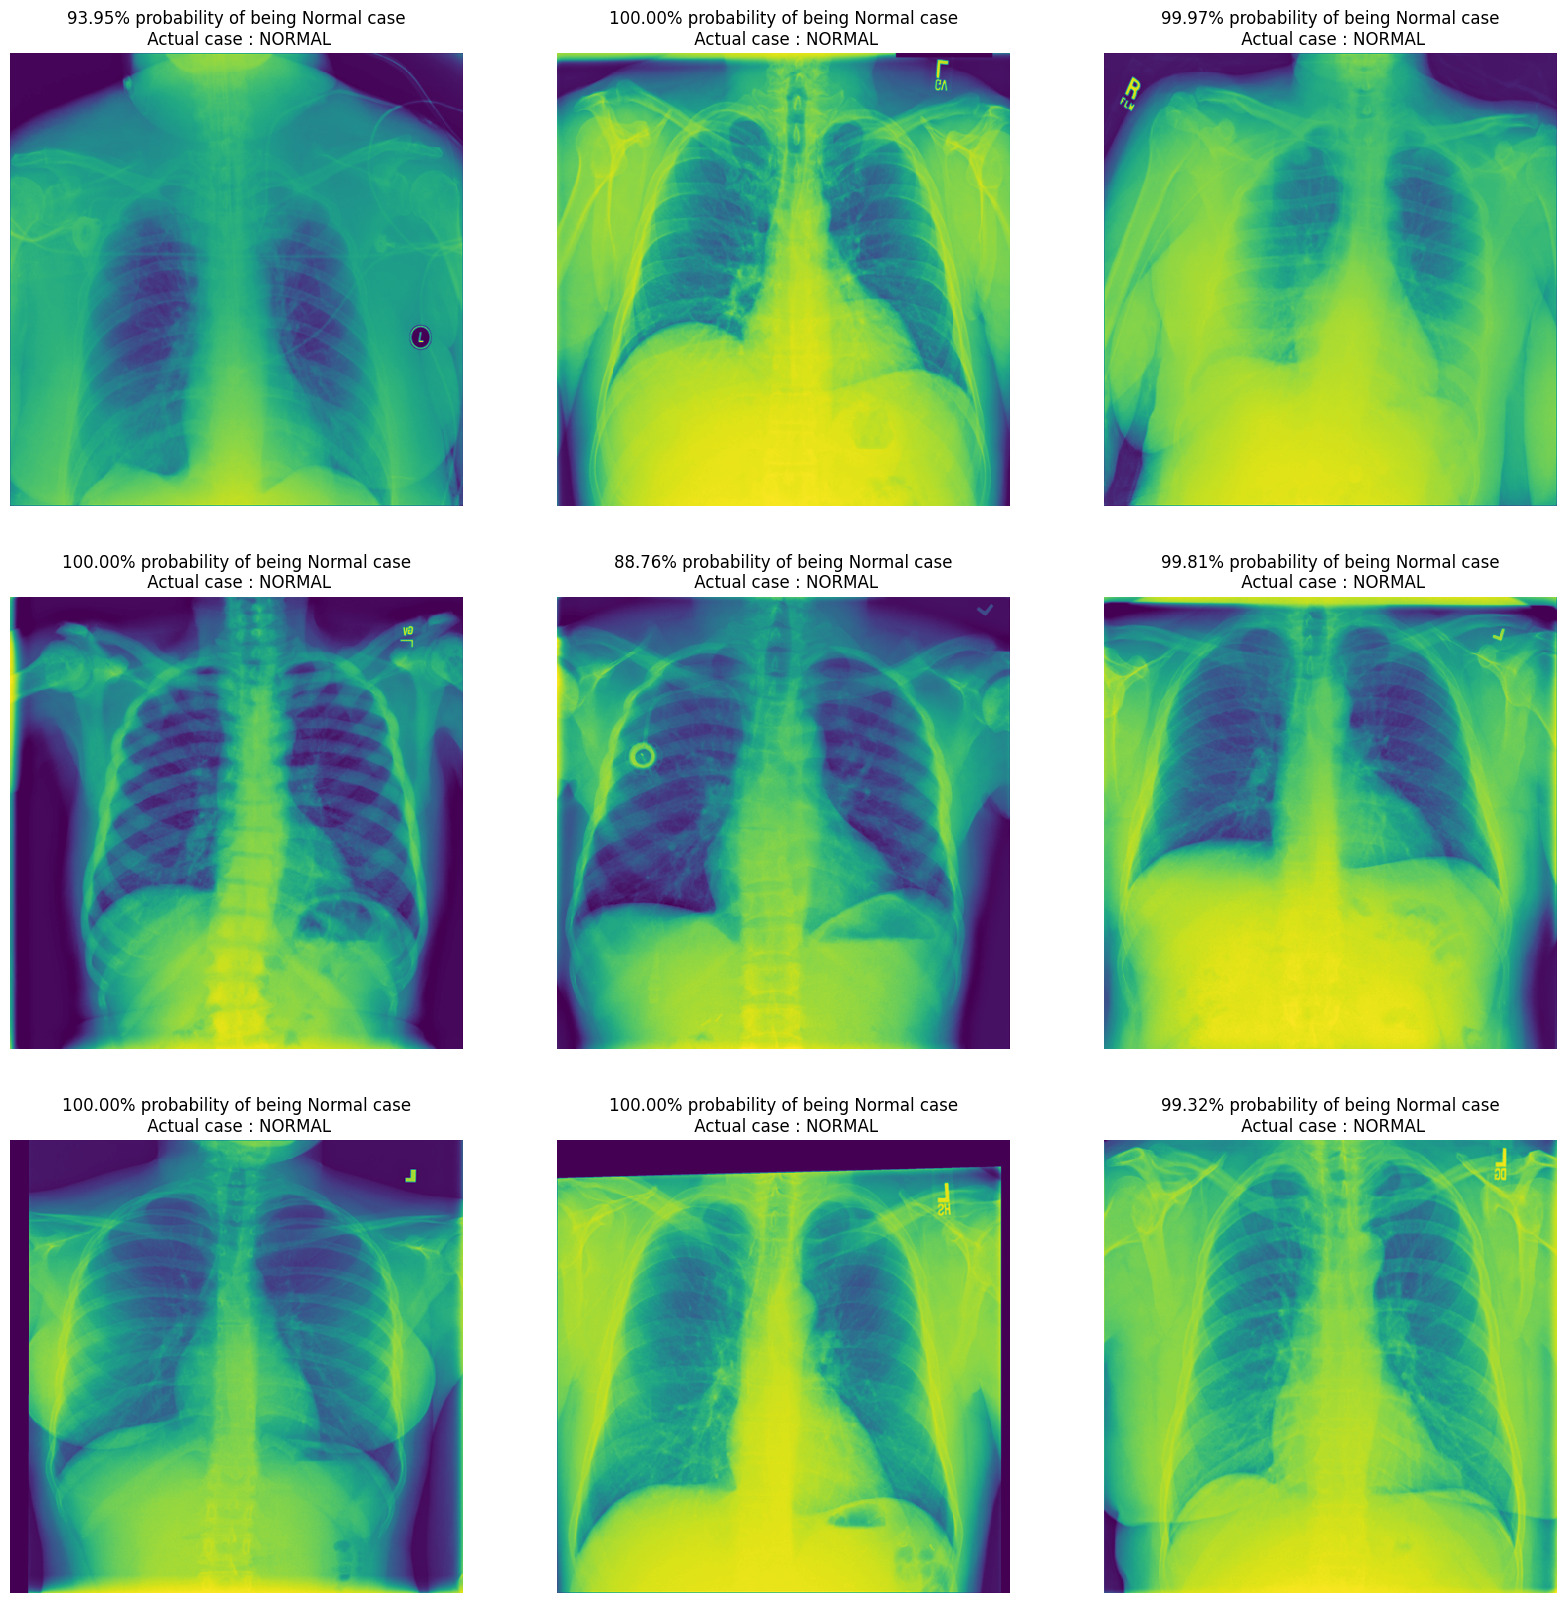

In [54]:
# reset lại trình lặp của tập dữ liệu test nhằm mục đích khi truy xuất lại dữ liệu sẽ bắt đầu từ đầu
test.reset()

# Lấy dữ liệu và nhãn từ tập dữ liệu Test
x = np.concatenate([next(test)[0] for i in range(len(test))])
y = np.concatenate([next(test)[1] for i in range(len(test))])

# Kiểm tra kích thước của x và y
print(x.shape)
print(y.shape)

# dùng Dictionary ánh xan nhãn thành văn bản
dic = {0: 'NORMAL', 1: 'TUBERCULOSIS'}

# Hiển thị hình ảnh và dự đoán
plt.figure(figsize=(20, 20))
for i in range(0 + 228, 9 + 228):
    plt.subplot(3, 3, (i - 228) + 1)
    if preds[i, 0] >= 0.5:
        out = '{:.2%} probability of being Tuberculosis case'.format(preds[i][0])
    else:
        out = '{:.2%} probability of being Normal case'.format(1 - preds[i][0])

    plt.title(out + "\n Actual case : " + dic.get(y[i]))
    plt.imshow(np.squeeze(x[i]))
    plt.axis('off')

plt.show()
